In [51]:
import sqlite3 as sq
import requests as rq #Import the requests library--a library that makes it easy to make HTTP requests to APIs
import time as time
import csv

In [52]:
#Open my Ravelry authentication values
path = 'C:/Users/Jamie/Desktop/RavelrySecret.txt' #Path to the file that holds my keys--the username and password given to me by Ravelry for my Basic Auth, read only app
mode = 'r' #read mode--I'll only need to read the username and password from the file

keys = [] #The list where I'll store my username and password
with open(path,mode) as f: #Open the file
    for line in f:
        keys.append(line) #The first line is the username, and the second line is the password--add each of these lines to the keys list

user = keys[0].rstrip() #The username is held in the first element of the keys list
pswd = keys[1].rstrip() #The password is the second element of the keys list

In [8]:
#Ping the search endpoing with no search parameters to get all patterns
response = rq.get('https://api.ravelry.com/patterns/search.json?page_size=10&page=1', auth=(user, pswd))
print(response)

<Response [200]>


In [9]:
print(response.json()['paginator'])

{'page': 1, 'last_page': 10000, 'results': 100000, 'page_count': 10000, 'page_size': 10}


But I only get 100 000 search results for any particular search. <br>
Maybe I'll have to segment the search. <br>
First, there are 4 crafts: crochet, knitting, machine knitting, and loom knitting -- I believe each pattern gets classified under only exactly one of these categories, because if you sum the number of patterns in those categories together you get the total number of available patterns. <br>
Machine knitting and loom knitting together have 5134 patterns as of 3/18/2018, so they can be scraped together.
Crochet has 264 999 patterns. I can further segment these patterns by patterns that have 1 color (44037 results) or patterns that have 2 or more colors (12466 results). <br>
Knitting has 482 968 patterns.
 <br> <br>
I was able to request a page size of 1000 and it worked, but I still only got 100 000 results back. It's probably better to do a smaller page size (maybe 100) and go through 1000 pages, since it took several seconds to get the data.
 <br> <br>
Since I'm scraping all of this pattern data anyway, I should save the date that the pattern was created with the pattern ID, since I can't get it from the other endpoint that I'll be pulling from to construct my data table.
 <br> <br>
What format should I save my list of pattern IDs and the dates created? Save as a csv file with two columns

In [27]:
#Test run
#Get all of the machine knitting patterns
#Get 100 patterns at a time (100 pattern results per page)
#Use the paginator from the first page of results to determine how many results pages there are
#Loop through the remaining pages
#Combine the pattern IDs as integers and the dates the patterns were created into tuples, then append these tuples to a list
#UPDATE: I realized that the creation date wasn't the pattern page creation date--I don't know what the creation date in pattern sources means.
#   So just save the pattern IDs.
#Search the pattern IDs for duplicates, remove tuples corresponding to duplicates
#Save the tuples into a CSV file, with one column for each list


#Make the first query to figure out how many pages there will be
#100 results per page, start with page 1 of the results, get the machine knitting patterns only, 
#and sort the results by the date created (sort it this way so I can roughly check that I'm getting the correct date strings)
pageSize = 100
searchVals = {'page_size': str(pageSize), 'page': '1', 'craft': 'machine-knitting', 'sort': 'created'}

response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
print(response) #Print the response code so we can check whether the query was successful

numPages = 3 #response.json()['paginator']['last_page'] #Number of pages of results
print('Making ',numPages,' requests: ',numPages,' pages of data with ',pageSize,' results per page.')
#I tested this code with numPages = 3 first, without saving the results

IDs = [] #Initialize the list of pattern IDs

#Loop through the pages of results, then through the results on each page
#Save the pattern ID numbers to a list
for page in range(1,numPages+1): #Redo the query for the first page too so that we can append all of those ID numbers below
    searchVals['page'] = str(page) #Set the page # of the search results to ask for
    response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd)) #Make the query
    print(response) #Print the response code to check that our query was successful
    
    time.sleep(5)
      
    try:
        patternData = response.json()['patterns']
        for pat in range(len(patternData)):
            
            try:
                IDs.append(patternData[pat]['id']) #Append the pattern ID numbers to the IDs list
                print(patternData[pat]['name']) #Print the names of the patterns just so I can check that I'm getting back machine knitting patterns
                #REMOVE THIS PRINT STATEMENT WHEN SCRAPING THE IDS OF THE LARGER PATTERN CATEGORIES
                
            except:
                print('Problem on page',page,', pattern ',pat)
                
    except:
        print('Problem on page ',page)
        
print(IDs)
    

<Response [200]>
Making  3  requests:  3  pages of data with  100  results per page.
<Response [200]>
Thin Blue Line Afghan
Diagonal Diamonds Sweater
Sweater con bolsillo y capucha
Yoke Sweaters The Easy Way
Cool Mint Smock Top
Stash Buster Poncho
Raglan Robot Jumper..
Pull à rayures
Yamasaki Sweater
# 09 Polo-Pulli
# 29 Rosenpulli
Mütze mit Schummelzöpfen
Knot Front Sweater
Storms Wollhose
Baymax Scarf
CSM Bird
Squishy Woven I-cord Rug
Baby blanket lin
Arm Warmers
Batman pants
# 42 Strickmaschinenpulli für Kinder
# 23 Ringelpullover
Machine-knit jacket
18" doll hat and mittens
Pusegenser til barn
January Icebergs Scarf
Bulky Gauge Toddler and Child Hood
Fair Isle Boot Cuffs
Wrist Warmers on the Addi King
Basic Sweater for Child
RetroWear
Tovede votter
Addi Childs Sleevless top
Addi Sleevless top/Singlet
Sail
CSM Megan's Mary Janes
Machine-Knit Round Yoked Pullover
Basic Children's Pants
Kranich
Camo Beanie
Baby Mitts and Hat
5 Heels for the CSM
Cabled Cowl
Easy Long Summer Scarf
Ombre

I checked the results above, and I believe they are machine knit patterns.

In [39]:
#Sort the list of IDs
IDs.sort()
print(len(IDs))

#Eliminate duplicates in the IDs list
IDs = set(IDs)

#Convert UniqueIDs into a list
IDs = list(IDs)
print(len(IDs))

# print(len(IDs))
# print(len(UniqueIDs))

# myList = [1,2,2,2,3,3,4,5,6,6,7]

# #Eliminate duplicates in the IDs list
# index = [] #A list of indices of the elements we will remove
# for i in range(len(myList)-1): #Be sure to stop at 1 less than the max index
#     if myList[i] == myList[i+1]:
#         index.append(i)
    
# del myList[index]


300
300


# Machine knitting patterns
Put everything together to scrape all the machine knitting pattern IDs:

In [47]:
#Get all of the machine knitting patterns
#Get 100 patterns at a time (100 pattern results per page)
#Use the paginator from the first page of results to determine how many results pages there are
#Loop through the pages
#Store the pattern IDs in a list
#Search the pattern IDs for duplicates, remove elements corresponding to duplicates
#Save the IDs into a CSV file


#Make the first query to figure out how many pages there will be
#100 results per page, start with page 1 of the results, get the machine knitting patterns only, 
#and sort the results by the date created (sort it this way so I can roughly check that I'm getting the correct date strings)
pageSize = 100
searchVals = {'page_size': str(pageSize), 'page': '1', 'craft': 'machine-knitting', 'sort': 'created'}

response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
print(response) #Print the response code so we can check whether the query was successful

numPages = response.json()['paginator']['last_page'] #Number of pages of results
print('Making ',numPages,' requests: ',numPages,' pages of data with ',pageSize,' results per page.')

IDs = [] #Initialize the list of pattern IDs

WaitTime = 5 #Number of seconds to wait between requests to avoid spooking the API
print('This code should take approximately ',WaitTime*numPages/60,' minutes to complete.')

#Loop through the pages of results, then through the results on each page
#Save the pattern ID numbers to a list
for page in range(1,numPages+1): #Redo the query for the first page too so that we can append all of those ID numbers below
    searchVals['page'] = str(page) #Set the page # of the search results to ask for
    response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd)) #Make the query
    print(response) #Print the response code to check that our query was successful
    
    time.sleep(WaitTime) #Wait for a few seconds between each request so as not to spook the API
      
    try:
        patternData = response.json()['patterns'] #This is a list containing one dictionary for each pattern result
        for pat in range(len(patternData)):
            
            try:
                IDs.append(patternData[pat]['id']) #Append the pattern ID numbers to the IDs list
                
            except:
                print('Problem on page',page,', pattern ',pat)
                
    except:
        print('Problem on page ',page)
        
#Sort the list of IDs
IDs.sort()
print('Number of IDs found: ',len(IDs))

#Eliminate duplicates in the IDs list by converting it to a set
IDs = set(IDs)

#Convert IDs set back into a list
IDs = list(IDs)
print('Number of unique IDs found: ',len(IDs))

<Response [200]>
Making  19  requests:  19  pages of data with  100  results per page.
This code should take approximately  1.5833333333333333  minutes to complete.
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
Number of IDs found:  1855
Number of unique IDs found:  1855


In [48]:
path = 'C:/Users/Jamie/Documents/MachineKnittingPatternIDs.txt'
mode = 'w'

IDstrings = map(str,IDs) #Convert the ID list into a list of strings
IDstrings = map(lambda x: x + '\n', IDstrings) #Add a newline character to each ID string
#Note that there will be an extra newline character at the end of the file

#Save the list of IDs as a text file
with open(path,mode) as out:
    out.writelines(map(str,IDstrings))

I successfully scraped and saved all of the machine knitting pattern IDs! There were 1855 machine knitting patterns as of 3/18/2018.

# Functions for scraping
Now write a function for the pattern ID scraping:

In [61]:
def scrapePatternIDs(numPages,searchVals,user,pswd,waitTime):
    #Loop through the pages of results, then through the results on each page
    #Save the pattern ID numbers to a list
    
    IDs = [] #Initialize the list of pattern IDs
    
    for page in range(1,numPages+1): #Redo the query for the first page too so that we can append all of those ID numbers below
    #Note that page is not a python index, but instead it is the index of the results page that we're asking the API to return.
    #This results page index starts at 1 (1 is the first page) and ends at numPages (numPages is the last page), which is why we use range(1,numPages+1).
        searchVals['page'] = str(page) #Set the page # of the search results to ask for
        response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd)) #Make the query
        print(response) #Print the response code to check that our query was successful
    
        time.sleep(waitTime) #Wait for a few seconds between each request so as not to spook the API
      
        try:
            patternData = response.json()['patterns'] #This is a list containing one dictionary for each pattern result
            for pat in range(len(patternData)):
            
                try:
                    IDs.append(patternData[pat]['id']) #Append the pattern ID numbers to the IDs list
                
                except:
                    print('Problem on page',page,', pattern ',pat)
                
        except:
            print('Problem on page ',page)
        
    #Sort the list of IDs
    IDs.sort()
    print('Number of IDs found: ',len(IDs))

    #Eliminate duplicates in the IDs list by converting it to a set
    IDs = set(IDs)

    #Convert IDs set back into a list
    IDs = list(IDs)
    print('Number of unique IDs found: ',len(IDs))
    
    return IDs

In [55]:
def saveIDs(IDs,path):
    
    mode = 'w' #put this file in write mode
    
    IDstrings = map(str,IDs) #Convert the ID list into a list of strings
    IDstrings = map(lambda x: x + '\n', IDstrings) #Add a newline character to each ID string
    #Note that there will be an extra newline character at the end of the file

    #Save the list of IDs as a CSV file
    with open(path,mode) as out:
        out.writelines(map(str,IDstrings))

In [57]:
def printPatternNames(response):
    #This function takes a Ravelry response from the search.json? endpoint and prints all the pattern names it finds
    #This function is indended to help with debugging, to ensure that the patterns you're getting back are the ones you expect
    patternData = response.json()['patterns']
    
    for i in range(len(patternData)):
        print(patternData[i]['name'])

# Loom knitting patterns
Scrape the IDs for all of the loom knitting patterns:

In [59]:
#Define scraping parameters
pageSize = 100 #Number of results to ask for per page
craft = 'loom-knitting' #Get the loom knitting patterns only
waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API

#100 results per page, start with page 1 of the results and sort the results by the date created*
searchVals = {'page_size': str(pageSize), 'page': '1', 'craft': craft, 'sort': 'created'} #searchVals is the list of parameters to send to the API

#Make an initial request to the API to figure out how many pages of results there will be for our desired pageSize
response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
print(response) #Print the response code so we can check whether the query was successful
printPatternNames(response) #Print the names of the patterns found in this first call, so that we can check that we are getting the patterns we expect
numPages = response.json()['paginator']['last_page'] #Number of pages of results

#Display some info about # of requests that will be made and # of results per page
print('Making ',numPages,' requests: ',numPages,' pages of data with ',pageSize,' results per page.')

#Display how long this code should take to run
print('This code should take approximately ',waitTime*numPages/60,' minutes to complete.')

#Perform the scraping to get a list of unique pattern IDs
IDs = scrapePatternIDs(numPages,searchVals,user,pswd,waitTime)

#(*my original thought for sorting by date created was that maybe it won't mess things up as much if new patterns get added
#during the scraping, since it will return the newest patterns first and maybe we'll be able to catch all the patterns even
#if they get shifted by a couple, as long as the new patterns don't push the results over the final page; as opposed to if the
#results were sorted by popularity then the changes would be spread out over the pages but I guess sorting by date added doesn't
#really help anything. IDK, I don't think it really matters for my purposes since I don't really need ALL patterns, just most.)

<Response [200]>
Chic Bonnet
cumulus cowl
Fair Isle Hat Collection I
Zoom Loom Keepsake Baby Blanket
Trixi the Bunny
Luck of the Irish Shamrock
Barrel Stitch Bag
Threaded Scarf Spiral Chemo Beanie #5
Threaded Scarf Basketweave Chemo Beanie #4
Threaded Scarf Spiral Chemo Beanie #3
Threaded Scarf Chemo Beanie #2
Threaded Scarf Chemo Beanie #1
Coffee Now Please Beanie
Visor Beanie
Alexis Slipper Socks
A-Basin Beanie
How to loom knit a cowl
Stonewash Beanie
Zig Then Zag
Dandelion Wishes Ski Hat
V Collar
Victorian Lace Hoodic
Victorian Lace Collar
Cowood
Seed Cowl
Rib and Seed Slouch Hat
Rib and Seed Collar
Faux Entrelac Hood
Rib and Garter Collar
Snow Games Hat
Twisted Fingerless Gloves
Stripes Hat
Thrummed Mittens
Winter Park Beanie
Basic Chunkie Pudgie
Noël à Poudlard
Paint Mines Scarf
Loom Knit Zebra
Loom Knit Totoro
Loom Knit Tiger
Loom Knit Reversible Dolls
Be There Fingerless Gloves
Woven Ladder Scarf
Loom Knit Fringed Bandana
Raspberry Stitch Loom Knitted Bag
Baby’s Elf Hat with Pom

In [62]:
#Save the list of IDs to a file
path = 'C:/Users/Jamie/Documents/LoomKnittingPatternIDs.txt'
saveIDs(IDs,path)

I successfully scraped the loom knitting pattern IDs! There were 3279 loom knitting patterns as of 3/19/2018.

# Crochet patterns with 1 color

Next I will scrape the crochet pattern IDs. 
<br><br>
There are a lot more crochet patterns--265 092 as of 3/19/2018. I will start with the patterns that use 1 color (44 061 patterns as of 3/19/2018.)
<br><br>
44 061 patterns is a lot more than the 3 279 machine knitting patterns. If I ask for 100 results per page and wait 5 seconds between each request, this scraping will take 37 minutes.
<br><br>
I would like to speed up the process a little bit. If I ask for 500 results per page and wait 5 seconds between requests, then it will take 7.3 minutes. I think that this is an acceptible amount of time, so I'll try this.

In [64]:
#Scrape the crochet pattern IDs for patterns with 1 color 
#(note that I've added 'colors': '1' to the searchVals dictionary, and increased pageSize to 500)
#Define scraping parameters
pageSize = 500 #Number of results to ask for per page
craft = 'crochet' #Get the crochet patterns only
waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API

#100 results per page, start with page 1 of the results and sort the results by the date created
searchVals = {'page_size': str(pageSize), 'page': '1', 'craft': craft, 'colors': '1', 'sort': 'created'} #searchVals is the list of parameters to send to the API

#Make an initial request to the API to figure out how many pages of results there will be for our desired pageSize
response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
print(response) #Print the response code so we can check whether the query was successful
printPatternNames(response) #Print the names of the patterns found in this first call, so that we can check that we are getting the patterns we expect
numPages = response.json()['paginator']['last_page'] #Number of pages of results

#Display some info about # of requests that will be made and # of results per page
print('Making ',numPages,' requests: ',numPages,' pages of data with ',pageSize,' results per page.')

#Display how long this code should take to run
print('This code should take approximately ',waitTime*numPages/60,' minutes to complete.')

<Response [200]>
Chasing Diamonds Tunic
Linden Bonnet
Basic Bonnet
Simple Lacy Scarf
Hrukka Bonnet
Pointy coasters
Tunisian Wavelength
Morning Sun fingerless mittens
Judith L shawl crochet
Flowers and Bows
Pyramid Falls Blanket
Phoenix Rose Baby Blanket
Holly's Cowl
Marcia's Cowl
Easter bunny
Infinity Crochet Upstream Blanket
Red Roundup
#100 Apricity Pullover Sweater
Spring Flirtations Poncho
Twoshirts Macerated Cabbage Festival Washcloth
Flower Greeting Card
Two-Rectangle Cardigan
Dude Cardigan
The Winnie Hooded Vest
Sailmaker
Miss Madelyn's Barbie Tutu
Laci Cardi
Feenspiegel
Tiny Snake
Starweave
Pointed Ends Scarf
Blueberry Shawl
Crimp Bonnet
Adente die kleine Ente
Greebo's Blanket
Spring Shamrocks
Nadine
The Crossbill Cardigan
Thaumantis
Floral Hexagon
Memento Mori Shawl
Chaqueta jaspeada con muestra de conchas
Stars and Lozenges
The Mattiee Hat
Glass holder and coaster set
Prom Queen Pookie
Mermaid Scale Fingerless Gloves
Butterflies in Flight
In A Whirl Scarf
Ruffle Sleeve Cardig

I checked the first few and the last few pattern names to make sure they corresponded to what I got from the Ravelry search GUI, and they did.
<br><br>
Now do the actual scraping:

In [65]:
#Perform the scraping to get a list of unique pattern IDs
IDs = scrapePatternIDs(numPages,searchVals,user,pswd,waitTime)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

And finally, save the list of 1-color crochet pattern IDs:

In [66]:
#Save the list of IDs to a file
path = 'C:/Users/Jamie/Documents/Crochet1ColorPatternIDs.txt'
saveIDs(IDs,path)

I successfully scraped and saved the 1-color crocheting patterns!
<br><br>
I started this run at 10:19am, and it made 34 requests by 10:30am--34 requests (of 500 results each) in about 11 minutes, so about 19 seconds per request. Since I told the code to wait 5 seconds between requests, this means that each request was taking around 14 seconds on its own to complete.

# Testing how long it takes to make requests with several results sizes
Next I want to see how long it takes to make 1-page requests of 100, 500, and 1000 results:

In [69]:
#Print how much time it takes to make 1-page requests for 100, 500, and 1000 results

#Request for 100 results
time_start = time.clock() #Start the timer
response = rq.get('https://api.ravelry.com/patterns/search.json?page_size=100&page=1', auth=(user, pswd)) #Make the request
print(response) #Make sure the request was successful
time_elapsed = (time.clock() - time_start) #Time it took to make the request
print('It took ',time_elapsed,' seconds to get 100 results')

#Request for 500 results
time_start = time.clock() #Start the timer
response = rq.get('https://api.ravelry.com/patterns/search.json?page_size=500&page=1', auth=(user, pswd)) #Make the request
print(response) #Make sure the request was successful
time_elapsed = (time.clock() - time_start) #Time it took to make the request
print('It took ',time_elapsed,' seconds to get 500 results')

#Request for 1000 results
time_start = time.clock() #Start the timer
response = rq.get('https://api.ravelry.com/patterns/search.json?page_size=1000&page=1', auth=(user, pswd)) #Make the request
print(response) #Make sure the request was successful
time_elapsed = (time.clock() - time_start) #Time it took to make the request
print('It took ',time_elapsed,' seconds to get 1000 results')

<Response [200]>
It took  2.0437919343385147  seconds to get 100 results
<Response [200]>
It took  8.650711450973176  seconds to get 500 results
<Response [200]>
It took  15.391216522577452  seconds to get 1000 results


The results from my tests of how much time it takes to make 1-page requests with 100, 500, and 1000 results per page are as follows: <br>
It took  2.2722127831948455 seconds to return  100 results<br>
It took  6.834837280737702  seconds to return  500 results<br>
It took 15.970784786724835  seconds to return 1000 results

 100 results:  2.27 s /  100 results = 0.027 s per result<br>
 500 results:  6.83 s /  500 results = 0.014 s per result<br>
1000 results: 16.97 s / 1000 results = 0.017 s per result

Two subsequent tests:<br>
2.62 for 100   = 0.026 s per result<br>
13.29 for 500  = 0.026<br>
14.82 for 1000 = 0.015<br>
<br>
2.04 for 100   = 0.020<br>
8.65 for 500   = 0.017<br>
15.39 for 1000 = 0.015

So it seems that getting 1000 results per page might be optimal.
<br><br>
Let's try it with more search parameters:

In [72]:
#Print how much time it takes to make 1-page requests for 100, 500, and 1000 results,
#this time with more search parameters

#Request for 100 results
time_start = time.clock() #Start the timer
response = rq.get('https://api.ravelry.com/patterns/search.json?page_size=100&page=1&craft=crochet&colors=1', auth=(user, pswd)) #Make the request
print(response) #Make sure the request was successful
time_elapsed = (time.clock() - time_start) #Time it took to make the request
print('It took ',time_elapsed,' seconds to get 100 results, for ',time_elapsed/100,' seconds per result')

#Request for 500 results
time_start = time.clock() #Start the timer
response = rq.get('https://api.ravelry.com/patterns/search.json?page_size=500&page=1&craft=crochet&colors=1', auth=(user, pswd)) #Make the request
print(response) #Make sure the request was successful
time_elapsed = (time.clock() - time_start) #Time it took to make the request
print('It took ',time_elapsed,' seconds to get 500 results, for ',time_elapsed/500,' seconds per result')

#Request for 1000 results
time_start = time.clock() #Start the timer
response = rq.get('https://api.ravelry.com/patterns/search.json?page_size=1000&page=1&craft=crochet&colors=1', auth=(user, pswd)) #Make the request
print(response) #Make sure the request was successful
time_elapsed = (time.clock() - time_start) #Time it took to make the request
print('It took ',time_elapsed,' seconds to get 1000 results, for ',time_elapsed/1000,' seconds per result')

<Response [200]>
It took  1.3956468523392687  seconds to get 100 results, for  0.013956468523392686  seconds per result
<Response [200]>
It took  8.550816653005313  seconds to get 500 results, for  0.017101633306010625  seconds per result
<Response [200]>
It took  14.529346397408517  seconds to get 1000 results, for  0.014529346397408518  seconds per result


First run:

It took  3.565867802069988  seconds to get 100 results, for  0.03565867802069988  seconds per result<br>
It took  13.789907355996547  seconds to get 500 results, for  0.027579814711993094  seconds per result<br>
It took  23.937227124290075  seconds to get 1000 results, for  0.023937227124290077  seconds per result

Second run:

It took  1.3956468523392687  seconds to get 100 results, for  0.013956468523392686  seconds per result<br>
It took  8.550816653005313  seconds to get 500 results, for  0.017101633306010625  seconds per result<br>
It took  14.529346397408517  seconds to get 1000 results, for  0.014529346397408518  seconds per result

Therefore, although the request times are somewhat variable, requesting 1000 results at a time seems to be optimal. The average time to make a 1000-result request from my 5 trials was 17s.<br>
And, if I am going to add 5 seconds between each request, then getting 1000 results at a time is definitely optimal, as the 1000-result request is usually a little faster than the other request sizes, and does not appear to be significantly slower than the other request types.

# Crochet patterns with more than 1 color
The next thing I need to do is scrape the IDs of the crochet patterns that use more than 1 color. There should be 12 473 patterns that match these search parameters.

According to the Ravelry Search gui url, the way to get patterns that use more than 1 color is 'colors=2%7C3%7C4%7C5%7C6'.

In [89]:
#Testing the 'colors=2%7C3%7C4%7C5%7C6' query

#This code is successful and returns the correct pattern for the search parameters:
response = rq.get('https://api.ravelry.com/patterns/search.json?page_size=10&page=1&craft=crochet&sort=created&colors=2%7C3%7C4%7C5%7C6', auth=(user, pswd)) #Make the request
print(response) #Print the response code
print(response.json()['patterns'][0]['name']) #Print the pattern name

#The following returns a 500 response, which according to the Ravelry API means 
#"500 Server Error: outside of OAuth flow, this signals an error on Ravelry's side. 
# We do receive an error notification but please report a bug."
# searchVals = {'page_size': '1', 'page': '1', 'craft': 'crochet', 'colors': '2%7C3%7C4%7C5%7C6', 'sort': 'created'} 
# response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
# print(response) #Print the response code
# print(response.json()['patterns'][0]['name']) #Print the pattern name

#This one is also successful!
searchVals = {'page_size': '1', 'page': '1', 'craft': 'crochet', 'colors': '2|3|4|5|6', 'sort': 'created'} 
response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
print(response) #Print the response code
print(response.json()['patterns'][0]['name']) #Print the pattern name

<Response [200]>
Honeycomb Shawl
<Response [200]>
Honeycomb Shawl


I realized that Ravelry uses the | character to designate an OR search, which is encoded with '%7C' in html. The requests package will automatically do the encoding for us, so we need to use the value '2|3|4|5|6' for the 'colors' key in searchVals.

In [90]:
#Crochet patterns with more than 1 color -- setup
#(note that I've added 'colors': '2|3|4|5|6' to the searchVals dictionary, and increased pageSize to 1000)
#Define scraping parameters
pageSize = 1000 #Number of results to ask for per page
craft = 'crochet' #Get the crochet patterns only
waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': '1', 'craft': craft, 'colors': '2|3|4|5|6', 'sort': 'created'} 
#searchVals is the list of parameters to send to the API

#Make an initial request to the API to figure out how many pages of results there will be for our desired pageSize
response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
print(response) #Print the response code so we can check whether the query was successful
printPatternNames(response) #Print the names of the patterns found in this first call, so that we can check that we are getting the patterns we expect
numPages = response.json()['paginator']['last_page'] #Number of pages of results

#Display some info about # of requests that will be made and # of results per page
print('Making ',numPages,' requests: ',numPages,' pages of data with ',pageSize,' results per page.')

#Display how long this code should take to run
timePerPage = waitTime + 17 #17 s is the approximate time it takes to make a 1000-results request
print('This code should take approximately ',timePerPage*numPages/60,' minutes to complete.')

<Response [200]>
Honeycomb Shawl
Mondays at the Library Shawl
Desert Steps Wrap
Amigurumi Goat
Tu-Tu Cute Bodice
Heathers Jacket
Skully Crop
Kranztier Hase
Simon
Hoban
Malcolm
Lily Mae Circle in A Square
Fox Blanket Pin
Unicorn, Sateenkaaren ratsu
Chicken Chicks and Chickies
Spencer Castle Cowl
Pixel Matrix
190 Girl Doll in an Easter Bunny Rabbit outfit
Leprechaun Boot Cuffs
Accent Yarn Scarf
Ribbed Plant Sweater
Lori Ann Poncho
Cotton & Lace Peasant Dress & Headband
Aquamarine
Ombré Shells Hat
The Sara Scarf
Siggi Schildkröte
Strawberry Bookmark
Pikkuisen peitto
#29 Pennywinkle Pullover
March Fairy
Grillhandschuh
Baby Giraffe mini Ragdoll
Giraffe Ragdoll
Houndstooth Squares Blanket
Sleepy chicken amigurumi
Easy Freeform Fancy Spiral
My little lamb bag
Lillehammer Knee High Socks
Charming Gingham Vase
The Little Basket
Simple-Shell Sea Turtle EXPANSION PACK
Penny the Pony
Rainbow Kaleidoscope
Arya Vest
Twilight Snowflake Afghan
Sparkle the Reindeer
Neat Little Nelli the Rat
Frozen rose

Making  13  requests:  13  pages of data with  1000  results per page.
This code should take approximately  4.766666666666667  minutes to complete.


I checked the Ravelry GUI to confirm that these patterns are indeed crochet patterns using more than 1 color.

The code predicts:<br>
Making  13  requests:  13  pages of data with  1000  results per page.<br>
This code should take approximately  4.766666666666667  minutes to complete.<br>

In [91]:
#Crochet patterns with more than 1 color -- scrape

time_start = time.clock() #Store the start time

IDs = scrapePatternIDs(numPages,searchVals,user,pswd,waitTime) #Perform the scraping to get a list of unique pattern IDs

time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
print('It took ',time_elapsed,' seconds to scrape these data.') #Print the elapsed time

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
Number of IDs found:  12472
Number of unique IDs found:  12472
It took  4016.8095741483266  seconds to scrape these data.


Unfortunately I messed up the start time code (fixed now) so I didn't get an accurate response for the # of seconds it took to scrape the multi-color crochet patterns.

In [92]:
#Crochet patterns with more than 1 color -- save

#Save the list of IDs to a file
path = 'C:/Users/Jamie/Documents/CrochetMultiColorPatternIDs.txt'
saveIDs(IDs,path)

# A function to print just the first 10 and last 10 pattern names from a request response

In [125]:
def print20PatternNames(response):
    #This function takes a Ravelry response from the search.json? endpoint and 
    #prints the first 10 and last 10 pattern names.
    #This function is indended to help with debugging, to ensure that the patterns you're getting back are the ones you expect
    patternData = response.json()['patterns']
    L = len(patternData) #Total number of patterns
    
    indices = list(range(10)) + list(range(L-10,L))
    
    for i in indices: #Print names of the first 10 and last 10 patterns
        print('pattern # ',i+1,': ',patternData[i]['name'])

# Knitting patterns with more than 1 color

In [126]:
#Knitting patterns with more than 1 color -- setup
#(note that I've added 'colors': '2|3|4|5|6' to the searchVals dictionary, and increased pageSize to 1000)
#Define scraping parameters
pageSize = 1000 #Number of results to ask for per page
craft = 'knitting' #Get the knitting patterns only
waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': '1', 'craft': craft, 'colors': '2|3|4|5|6', 'sort': 'created'} 
#searchVals is the list of parameters to send to the API

#Make an initial request to the API to figure out how many pages of results there will be for our desired pageSize
time_start = time.clock() #Store the start time
response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
print(response) #Print the response code so we can check whether the query was successful
print('It took ',time_elapsed,' seconds to make one request.') #Print the elapsed time for this one request
print20PatternNames(response) #Print the names of the patterns found in this first call, so that we can check that we are getting the patterns we expect
numPages = response.json()['paginator']['last_page'] #Number of pages of results

#Display some info about # of requests that will be made and # of results per page
print('Making ',numPages,' requests: ',numPages,' pages of data with ',pageSize,' results per page.')

#Display how long this code should take to run
timePerPage = waitTime + 17 #17 s is the approximate time it takes to make a 1000-results request
print('This code should take approximately ',timePerPage*numPages/60,' minutes to complete.')

<Response [200]>
It took  14.865794822952012  seconds to make one request.
pattern #  1 :  Henry's Scarf
pattern #  2 :  Pine Hill
pattern #  3 :  Posh
pattern #  4 :  Spick and Span Wash Cloths
pattern #  5 :  Fly, you Fools
pattern #  6 :  Reversible Kitty Cowl
pattern #  7 :  Phone Pouch
pattern #  8 :  La Marea
pattern #  9 :  Fourteen Petals Cap
pattern #  10 :  Pig Butt Coaster
pattern #  991 :  Gradient Cowl
pattern #  992 :  Vuokko
pattern #  993 :  Littermates
pattern #  994 :  September House
pattern #  995 :  Puddle Wonderful Cowl
pattern #  996 :  Love Hearts Hat
pattern #  997 :  Mabel's Maze
pattern #  998 :  Hazel's Stripes
pattern #  999 :  The Sisterhood Hat
pattern #  1000 :  Jersey Picos Nórdicos
Making  44  requests:  44  pages of data with  1000  results per page.
This code should take approximately  16.133333333333333  minutes to complete.


Results were:<br>
Making  44  requests:  44  pages of data with  1000  results per page.<br>
This code should take approximately  16.133333333333333  minutes to complete.<br>
The first and last 10 patterns do match the patterns I see using the Ravelry search GUI.

In [127]:
#Knitting patterns with more than 1 color -- scrape

time_start = time.clock() #Store the start time

IDs = scrapePatternIDs(numPages,searchVals,user,pswd,waitTime) #Perform the scraping to get a list of unique pattern IDs

time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
print('It took ',time_elapsed,' seconds to scrape these data.') #Print the elapsed time

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
Number of IDs found:  43529
Number of unique IDs found:  43529
It took  1050.7235714940616  seconds to scrape these data.


Success! It took 1051 s = 17.5 minutes to complete.

In [128]:
#Knitting patterns with more than 1 color -- save

#Save the list of IDs to a file
path = 'C:/Users/Jamie/Documents/KnittingMultiColorPatternIDs.txt'
saveIDs(IDs,path)

# How to split up single-color knitting patterns?
Next I have to split up the single-color knitting patterns.

It looks like the 'rating' attribute splits the single-color knitting patterns into non-overlapping groups, because if you add up the search results with each rating you get the total # of single-color knitting patterns. Also, when I try to do an AND search with different ratings values there are no search results found. This makes sense, as a patter should only have one rating value. One downside is that a pattern's rating might change over time, so it's possible that the ratings could change slightly while I scrape. I haven't seen duplicate pattern IDs in any of the other groups so far, but it's possible I could see duplicates here. Regardless, I don't anticipate this being a large source of inaccuracy--just small fluctuations.

I can split the single-color knitting patterns into groups as follows:<br>
'ratings=0|1|2|3' -- 40 388 patterns<br>
'ratings=4' -- 68 684 patterns<br>
'ratings=5' -- 86 471 patterns<br>

# Single-color knitting patterns that are rated 0, 1, 2, or 3 stars

In [129]:
#Knitting patterns with 1 color that are rated 0, 1, 2, or 3 stars -- setup
#(note that I've added 'colors': '1' and 'ratings': '0|1|2|3' to the searchVals dictionary)
#Define scraping parameters
pageSize = 1000 #Number of results to ask for per page
craft = 'knitting' #Get the knitting patterns only
waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': '1', 'craft': craft, 'colors': '1', 'ratings': '0|1|2|3', 'sort': 'created'} 
#searchVals is the list of parameters to send to the API

#Make an initial request to the API to figure out how many pages of results there will be for our desired pageSize
time_start = time.clock() #Store the start time
response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
print(response) #Print the response code so we can check whether the query was successful
print('It took ',time_elapsed,' seconds to make one request.') #Print the elapsed time for this one request
print20PatternNames(response) #Print the names of the patterns found in this first call, so that we can check that we are getting the patterns we expect
numPages = response.json()['paginator']['last_page'] #Number of pages of results

#Display some info about # of requests that will be made and # of results per page
print('Making ',numPages,' requests: ',numPages,' pages of data with ',pageSize,' results per page.')

#Display how long this code should take to run
timePerPage = waitTime + 17 #17 s is the approximate time it takes to make a 1000-results request
print('This code should take approximately ',timePerPage*numPages/60,' minutes to complete.')

<Response [200]>
It took  28.345693085197126  seconds to make one request.
pattern #  1 :  Tanglewood Hat Bulky
pattern #  2 :  Tanglewood Hat Worsted
pattern #  3 :  Square-Back Chunky Bonnet
pattern #  4 :  Tanglewood Mitts Worsted
pattern #  5 :  Tanglewood Mitts Bulky
pattern #  6 :  Stulpe Zopfspirale
pattern #  7 :  Wintery Mix
pattern #  8 :  Fugleflugtlinjen
pattern #  9 :  Ribbons Socks
pattern #  10 :  Kodiak Cowl
pattern #  991 :  Splice Cowl
pattern #  992 :  Flames Cowl
pattern #  993 :  Diamonds Sparkle Hat
pattern #  994 :  Thrummed Mittens
pattern #  995 :  Changing Leaves Shawl
pattern #  996 :  Lorna's Leaves Cowl
pattern #  997 :  Basic Ole Man Socks
pattern #  998 :  "Bow"tiful Beanie
pattern #  999 :  Tributary Hat
pattern #  1000 :  Lavender Legwarmers
Making  41  requests:  41  pages of data with  1000  results per page.
This code should take approximately  15.033333333333333  minutes to complete.


Results:<br>
It took  28.345693085197126  seconds to make one request.<br>
Making  41  requests:  41  pages of data with  1000  results per page.<br>
This code should take approximately  15.033333333333333  minutes to complete.

The first and last 10 patterns do match the patterns I see in the Ravelry GUI.

In [130]:
#Knitting patterns with 1 color that are rated 0, 1, 2, or 3 stars -- scrape

time_start = time.clock() #Store the start time

IDs = scrapePatternIDs(numPages,searchVals,user,pswd,waitTime) #Perform the scraping to get a list of unique pattern IDs

time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
print('It took ',time_elapsed,' seconds to scrape these data.') #Print the elapsed time

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
Number of IDs found:  40388
Number of unique IDs found:  40388
It took  828.4173998542974  seconds to scrape these data.


Success! It took  828 seconds = 13.8 minutes

In [131]:
#Knitting patterns with 1 color that are rated 0, 1, 2, or 3 stars -- save

#Save the list of IDs to a file
path = 'C:/Users/Jamie/Documents/Knitting1ColorRating0123PatternIDs.txt'
saveIDs(IDs,path)

# Single-color knitting patterns that are rated 4 stars
I expect 68 684 patterns.

In [132]:
#Knitting patterns with 1 color that are rated 4 stars -- setup
#(note that I've added 'colors': '1' and 'ratings': '4' to the searchVals dictionary)
#Define scraping parameters
pageSize = 1000 #Number of results to ask for per page
craft = 'knitting' #Get the knitting patterns only
waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': '1', 'craft': craft, 'colors': '1', 'ratings': '4', 'sort': 'created'} 
#searchVals is the list of parameters to send to the API

#Make an initial request to the API to figure out how many pages of results there will be for our desired pageSize
time_start = time.clock() #Store the start time
response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
print(response) #Print the response code so we can check whether the query was successful
print('It took ',time_elapsed,' seconds to make one request.') #Print the elapsed time for this one request
print20PatternNames(response) #Print the names of the patterns found in this first call, so that we can check that we are getting the patterns we expect
numPages = response.json()['paginator']['last_page'] #Number of pages of results

#Display some info about # of requests that will be made and # of results per page
print('Making ',numPages,' requests: ',numPages,' pages of data with ',pageSize,' results per page.')

#Display how long this code should take to run
timePerPage = waitTime + 17 #17 s is the approximate time it takes to make a 1000-results request
print('This code should take approximately ',timePerPage*numPages/60,' minutes to complete.')

<Response [200]>
It took  13.321766629815102  seconds to make one request.
pattern #  1 :  Blackberry Socks
pattern #  2 :  Baby Ocean Dream Sweater
pattern #  3 :  L'Équinoxe du printemps
pattern #  4 :  Bain
pattern #  5 :  Fither
pattern #  6 :  Tall Chevron Cowl
pattern #  7 :  Say
pattern #  8 :  Cabled Scarf 3274
pattern #  9 :  Illuminati Shawl
pattern #  10 :  Sidereal
pattern #  991 :  Concept 3-26 Jacket
pattern #  992 :  Luggy Socks
pattern #  993 :  Kobuk Tee
pattern #  994 :  Boat Neck Sweater 2 to 4 years
pattern #  995 :  #SockVirgin
pattern #  996 :  Tessarae
pattern #  997 :  Auri
pattern #  998 :  Regenboog
pattern #  999 :  #05 Shetland Twist Wrap
pattern #  1000 :  178-63 Istanbul
Making  69  requests:  69  pages of data with  1000  results per page.
This code should take approximately  25.3  minutes to complete.


Results:<br>
It took  13.321766629815102  seconds to make one request.<br>
Making  69  requests:  69  pages of data with  1000  results per page.<br>
This code should take approximately  25.3  minutes to complete.

The first and last 10 patterns do match the patterns I see in the Ravelry GUI.

In [133]:
#Knitting patterns with 1 color that are rated 4 stars -- scrape

time_start = time.clock() #Store the start time

IDs = scrapePatternIDs(numPages,searchVals,user,pswd,waitTime) #Perform the scraping to get a list of unique pattern IDs

time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
print('It took ',time_elapsed/60,' minutes to scrape these data.') #Print the elapsed time

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

Success! It took  23 minutes, and I got 68 684 patterns--exactly the expected number.

In [134]:
#Knitting patterns with 1 color that are rated 4 stars -- save

#Save the list of IDs to a file
path = 'C:/Users/Jamie/Documents/Knitting1ColorRating4PatternIDs.txt'
saveIDs(IDs,path)

# Single-color knitting patterns that are rated 5 stars
I expect 86 470 patterns.

In [135]:
#Knitting patterns with 1 color that are rated 4 stars -- setup
#(note that I've added 'colors': '1' and 'ratings': '5' to the searchVals dictionary)
#Define scraping parameters
pageSize = 1000 #Number of results to ask for per page
craft = 'knitting' #Get the knitting patterns only
waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': '1', 'craft': craft, 'colors': '1', 'ratings': '5', 'sort': 'created'} 
#searchVals is the list of parameters to send to the API

#Make an initial request to the API to figure out how many pages of results there will be for our desired pageSize
time_start = time.clock() #Store the start time
response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
print(response) #Print the response code so we can check whether the query was successful
print('It took ',time_elapsed,' seconds to make one request.') #Print the elapsed time for this one request
print20PatternNames(response) #Print the names of the patterns found in this first call, so that we can check that we are getting the patterns we expect
numPages = response.json()['paginator']['last_page'] #Number of pages of results

#Display some info about # of requests that will be made and # of results per page
print('Making ',numPages,' requests: ',numPages,' pages of data with ',pageSize,' results per page.')

#Display how long this code should take to run
timePerPage = waitTime + 17 #17 s is the approximate time it takes to make a 1000-results request
print('This code should take approximately ',timePerPage*numPages/60,' minutes to complete.')

<Response [200]>
It took  14.204724920899025  seconds to make one request.
pattern #  1 :  Boot Camp Socks
pattern #  2 :  Powder Keg Beanie
pattern #  3 :  Elven Princess
pattern #  4 :  Lacy Bits Poncho
pattern #  5 :  Kräutergarten
pattern #  6 :  Flechtwerk
pattern #  7 :  Zopf um Zopf
pattern #  8 :  Kirschblüte
pattern #  9 :  Easter Lily Cowl//Påskeliljehals
pattern #  10 :  Balloons
pattern #  991 :  Chunky Cowl
pattern #  992 :  Sunday Morning
pattern #  993 :  Sub Zero
pattern #  994 :  As Far As the Eye Can See
pattern #  995 :  Triforce Cowl
pattern #  996 :  Mocaccino
pattern #  997 :  Mentor MKAL
pattern #  998 :  Snug Rustic
pattern #  999 :  Mae Cardigan
pattern #  1000 :  Alfa
Making  87  requests:  87  pages of data with  1000  results per page.
This code should take approximately  31.9  minutes to complete.


Results:<br>
It took  14.204724920899025  seconds to make one request.<br>
Making  87  requests:  87  pages of data with  1000  results per page.<br>
This code should take approximately  31.9  minutes to complete.

The first and last 10 patterns do match the patterns I see in the Ravelry GUI.

In [136]:
#Knitting patterns with 1 color that are rated 5 stars -- scrape

time_start = time.clock() #Store the start time

IDs = scrapePatternIDs(numPages,searchVals,user,pswd,waitTime) #Perform the scraping to get a list of unique pattern IDs

time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
print('It took ',time_elapsed/60,' minutes to scrape these data.') #Print the elapsed time

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

Success! It took  29 minutes and 86 470 patterns were found.

In [137]:
#Knitting patterns with 1 color that are rated 5 stars -- save

#Save the list of IDs to a file
path = 'C:/Users/Jamie/Documents/Knitting1ColorRating5PatternIDs.txt'
saveIDs(IDs,path)

Scrape time for each category:
Machine knitting: 1855 patterns in about 2 minutes, 428 patterns/min, requesting 100 patterns at a time<br>
Loom knitting: 3279 patterns in about 3 minutes, 1093 patterns/min, requesting 100 patterns at a time<br>
Crochet, 1-color: 44 061 in about 28 minutes, 1573 patterns/min, requesting 500 patterns at a time<br>
Crochet, multi-color: 12 472 patterns in about 5 minutes, 2495 patterns/min, requesting 1000 patterns at a time<br>
Knitting, multi-color: 43 529 patterns in 18 minutes, 2418 patterns/min, requesting 1000 patterns at a time<br>
Knitting, 1-color, rating 0,1,2,3: 40 388 patterns in 14 minutes, 2885 patterns/min, requesting 1000 patterns at a time<br>
Knitting, 1-color, rating 4: 68 684 patterns in 23 minutes, 2986 patterns/min, requesting 1000 patterns at a time<br>
Knitting, 1-color, rating 5: 86 470 patterns in 29 minutes, 2982 patterns/min, requesting 1000 patterns at a time<br>
Total: 300 733 patterns

Oh no! I haven't scraped all of the patterns! There should be 753 382 total patterns! Blargh!<br>
After some digging, I realized that the patterns with # of colors attribute does NOT add up to the total # of patterns.<br>
I will have to go back and scrape the Crochet and Knitting patterns that do NOT have a color attribute. I will also have to subdivide each of these categories. Blargh.

# Check whether the IDs I've scraped so far are unique

In [151]:
root = 'C:/Users/Jamie/Documents/RavelryPatternIDs/'
extension = '.txt'
fileNames = ['Crochet1ColorPatternIDs','CrochetMultiColorPatternIDs','Knitting1ColorRating4PatternIDs',
             'Knitting1ColorRating0123PatternIDs','KnittingMultiColorPatternIDs','LoomKnittingPatternIDs',
             'MachineKnittingPatternIDs','Knitting1ColorRating5PatternIDs']

mode = 'r'

IDs = [] #The list where I'll store the ID numbers
for fileName in fileNames:
    path = root + fileName + extension
    with open(path,mode) as f: #Open the file
        for line in f:
            IDs.append(line.rstrip()) #Remove trailing newlines before appending each line

print(len(IDs),' ID numbers found.')
IDs = set(IDs) #Convert the list of IDs to a set to remove duplicate ID numbers
IDs = list(IDs) #Convert the set of IDs back to a list
print(len(IDs),' unique ID numbers found.')

300738  ID numbers found.
300738  unique ID numbers found.


Results: <br>
300738  ID numbers found.<br>
300738  unique ID numbers found.

I got a few more patterns than I expected, so I'll need to double check my pattern counts.

But so far I don't have any overlapping pattern IDs, which is good! Now I just have to figure out how to segment the rest of Ravelry's patterns.

# A function for scraping and saving

In [154]:
def scrapeAndSaveRav1(searchVals,waitTime,filePath):
    #Make an initial request to the API to figure out how many pages of results there will be for our desired pageSize
    time_start = time.clock() #Store the start time
    response = rq.get('https://api.ravelry.com/patterns/search.json?', params = searchVals, auth = (user,pswd))
    time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
    print(response) #Print the response code so we can check whether the query was successful
    print('It took ',time_elapsed,' seconds to make one request.') #Print the elapsed time for this one request
    print20PatternNames(response) #Print the names of the patterns found in this first call, so that we can check that we are getting the patterns we expect
    numPages = response.json()['paginator']['last_page'] #Number of pages of results

    #Display some info about # of requests that will be made and # of results per page
    print('Making ',numPages,' requests: ',numPages,' pages of data with ',pageSize,' results per page.')

    #Display how long this code should take to run
    timePerPage = waitTime + time_elapsed #time_elapsed is the approximate time it takes to make a 1000-results request,
    #based on the first request above.
    print('This code should take approximately ',timePerPage*numPages/60,' minutes to complete.')
    
    #Start the scraping process
    time_start = time.clock() #Store the start time
    IDs = scrapePatternIDs(numPages,searchVals,user,pswd,waitTime) #Perform the scraping to get a list of unique pattern IDs
    time_elapsed = (time.clock() - time_start) #Time it took to perform the scraping
    print('It took ',time_elapsed/60,' minutes to scrape these data.') #Print the elapsed time
    
    #Save the list of IDs to a file
    saveIDs(IDs,filePath)

# K1--Patterns with these attributes:
craft=knitting<br>
colors=-6+-5+-4+-3+-2+-1<br>
ratings=0<br>
source-type=-eBook+-webzine+-website+-booklet+-magazine+-book<br>

I expect 49 289 patterns.

In [155]:
#K1
#Define scraping parameters
pageSize = 1000 #Number of results to ask for per page
page = '1' #Start with the first page, the function will then cycle through the pages for us
craft = 'knitting' #Knitting patterns
colors = '-6+-5+-4+-3+-2+-1' #Patterns that don't specify any number of colors
ratings = '0' #Patterns that have 0 stars
sort = 'created' #Sort the patterns in order of when the pattern page was created
sourceType = '-eBook+-webzine+-website+-booklet+-magazine+-book' #Patterns that don't have any source type specified

waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API
filePath = 'C:/Users/Jamie/Documents/K1PatternIDs.txt' #Place to save the IDs in a text file

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': page, 'craft': craft, 'colors': colors, 'ratings': ratings, 'source-type': sourceType, 'sort': sort} 
#searchVals is the list of parameters to send to the API

scrapeAndSaveRav1(searchVals,waitTime,filePath)

<Response [200]>
It took  13.27616231678985  seconds to make one request.
pattern #  1 :  Vertigo Mittens
pattern #  2 :  Undulation Adoration
pattern #  3 :  Stockinette Headband
pattern #  4 :  Her Favorite Slippers
pattern #  5 :  Little Meg Shawl
pattern #  6 :  Poncho Asato II
pattern #  7 :  Dots and Bombom
pattern #  8 :  Midnight Train Fold Brim Hat
pattern #  9 :  Irish Cable Bunting Bag
pattern #  10 :  The Savannah Watchman Cap
pattern #  991 :  V-Neck Raglan Baby Sweater
pattern #  992 :  The Gruffalo's Child
pattern #  993 :  Seraphina Twisted Cowl
pattern #  994 :  Candlelit Angel Christmas Stocking
pattern #  995 :  3 Lacy Ripple Stoles
pattern #  996 :  Tea Time
pattern #  997 :  Easter Egg Cozy:flamingo,owl,unicorn
pattern #  998 :  Verzopft_nicht_vernäht
pattern #  999 :  Olympia Beanie
pattern #  1000 :  Fuse Hat
Making  50  requests:  50  pages of data with  1000  results per page.
This code should take approximately  15.230135263991542  minutes to complete.
<Respon

K1 results: <br>
The first and last 10 patterns do match the Ravelry GUI's search.<br>
It took  13.27616231678985  seconds to make one request.<br>
Making  50  requests:  50  pages of data with  1000  results per page.<br>
This code should take approximately  15.230135263991542  minutes to complete.<br>
Number of IDs found:  49289<br>
Number of unique IDs found:  49289<br>
It took  16.024443337799553  minutes to scrape these data.<br>
It found exactly the same # of patterns as expected.

# K2--Patterns with these attributes:
craft=knitting<br>
colors=-6+-5+-4+-3+-2+-1<br>
ratings=0<br>
source-type=eBook|webzine|booklet|magazine|book (no website)<br>

I expect 72 594 patterns.

In [156]:
#K2
#Define scraping parameters
scrapeID = 'K2' #A name to help me identify different files of ID numbers
craft = 'knitting' #Knitting patterns
colors = '-6+-5+-4+-3+-2+-1' #Patterns that don't specify any number of colors
ratings = '0' #Patterns that have 0 stars
sourceType = 'eBook|webzine|booklet|magazine|book' #Patterns with any source type other than website
pageSize = 1000 #Number of results to ask for per page
page = '1' #Start with the first page, the function will then cycle through the pages for us
sort = 'created' #Sort the patterns in order of when the pattern page was created

waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API
filePath = 'C:/Users/Jamie/Documents/' + scrapeID + 'PatternIDs.txt' #Place to save the IDs in a text file

#searchVals is the list of parameters to send to the API
searchVals = {'page_size': str(pageSize), 'page': page, 'craft': craft, 'colors': colors, 'ratings': ratings, 'source-type': sourceType, 'sort': sort} 

#Perform the scraping
scrapeAndSaveRav1(searchVals,waitTime,filePath)

<Response [200]>
It took  13.441188757395139  seconds to make one request.
pattern #  1 :  Pink Ruby Toque
pattern #  2 :  #29a Cap
pattern #  3 :  Ivy Pattern
pattern #  4 :  38. Lapsen panda-panta
pattern #  5 :  #27 Brick-Pattern Cardigan
pattern #  6 :  MKG Many-Striped Mittens
pattern #  7 :  #06 Missoni Banded Tunic
pattern #  8 :  August
pattern #  9 :  #51 段染めの帽子
pattern #  10 :  40. Miehen kennoneuleinen pipo ja kaulahuivi
pattern #  991 :  21 Oriental Flair
pattern #  992 :  Spectacular Stripes
pattern #  993 :  Five Fancy Stitches for Mufflers: Triangle Stitch
pattern #  994 :  Pavillion Poncho
pattern #  995 :  Pergola Boho Bag
pattern #  996 :  Portico Hoodie/Crew
pattern #  997 :  Sombra Pullover
pattern #  998 :  Banana Leaf Duster Vest
pattern #  999 :  Eclipse Hi-Lo Tank
pattern #  1000 :  Cloud Cocoon Vest
Making  73  requests:  73  pages of data with  1000  results per page.
This code should take approximately  22.43677965483075  minutes to complete.
<Response [200]>

K2 results:<br>
The first and last 10 patterns do match the Ravelry GUI's search.<br>
It took  13.441188757395139  seconds to make one request.<br>
Making  73  requests:  73  pages of data with  1000  results per page.<br>
This code should take approximately  22.43677965483075  minutes to complete.
Number of IDs found:  72591<br>
Number of unique IDs found:  72591<br>
It took  23.061956997505572  minutes to scrape these data.<br>

# K3--Patterns with these attributes:
craft=knitting<br>
colors=-6+-5+-4+-3+-2+-1<br>
ratings=0<br>
source-type=website<br>

I expect 52 968 patterns.

In [157]:
#K3
#Define scraping parameters
scrapeID = 'K3'
craft = 'knitting' #Knitting patterns
colors = '-6+-5+-4+-3+-2+-1' #Patterns that don't specify any number of colors
ratings = '0' #Patterns that have 0 stars
sourceType = 'website' #Patterns with any source type other than website
pageSize = 1000 #Number of results to ask for per page
page = '1' #Start with the first page, the function will then cycle through the pages for us
sort = 'created' #Sort the patterns in order of when the pattern page was created

waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API
filePath = 'C:/Users/Jamie/Documents/' + scrapeID + 'PatternIDs.txt' #Place to save the IDs in a text file

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': page, 'craft': craft, 'colors': colors, 'ratings': ratings, 'source-type': sourceType, 'sort': sort} 
#searchVals is the list of parameters to send to the API

scrapeAndSaveRav1(searchVals,waitTime,filePath)

<Response [200]>
It took  13.232490740687354  seconds to make one request.
pattern #  1 :  Lillian Cardigan
pattern #  2 :  38. Lapsen panda-panta
pattern #  3 :  Celtic Cable & Rib Cowl
pattern #  4 :  Salcombe Top
pattern #  5 :  Mitered Pillow
pattern #  6 :  Cedar Ledge Cardigan
pattern #  7 :  Naptime Dreams Baby Romper
pattern #  8 :  Cedar Ledge Pullover
pattern #  9 :  2018 GAL: Discworld (knit)
pattern #  10 :  Spruce Point Pullover
pattern #  991 :  Santa & Mrs Claus
pattern #  992 :  Männerpullover aus Mohair
pattern #  993 :  Tweed Scarf
pattern #  994 :  187-9 Blackberry Crush
pattern #  995 :  187-14 Adele
pattern #  996 :  188-35 Marea
pattern #  997 :  186-16 Miss Flora Cardi
pattern #  998 :  Rogue River Reticule
pattern #  999 :  Fairest Fish of All
pattern #  1000 :  Metolius River Cowl
Making  53  requests:  53  pages of data with  1000  results per page.
This code should take approximately  16.105366820940496  minutes to complete.
<Response [200]>
<Response [200]>


K3 results:<br>
The first and last 10 patterns do match the Ravelry GUI's search.<br>
It took  13.232490740687354  seconds to make one request.<br>
Making  53  requests:  53  pages of data with  1000  results per page.<br>
This code should take approximately  16.105366820940496  minutes to complete.<br>
Number of IDs found:  52966<br>
Number of unique IDs found:  52966<br>
It took  17.025275698926755  minutes to scrape these data.<br>
Two fewer patterns were found than expected. I just redid the Ravelry GUI search, and found 52 966 (same as what my code found.) So either I wrote it down wrong when I searched initially, or a net of 2 patterns were removed during the scraping. No big deal either way.

# K4--patterns with these attributes:
craft=knitting<br>
colors=-6+-5+-4+-3+-2+-1<br>
ratings=1|2|3|4|5<br>

I expect 80 738 patterns.

In [158]:
#K4
#Define scraping parameters
scrapeID = 'K4'
craft = 'knitting' #Knitting patterns
colors = '-6+-5+-4+-3+-2+-1' #Patterns that don't specify any number of colors
ratings = '1|2|3|4|5' #Patterns that have 1, 2, 3, 4, or 5 stars
#(removed the source-type attribute specification)
pageSize = 1000 #Number of results to ask for per page
page = '1' #Start with the first page, the function will then cycle through the pages for us
sort = 'created' #Sort the patterns in order of when the pattern page was created

waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API
filePath = 'C:/Users/Jamie/Documents/' + scrapeID + 'PatternIDs.txt' #Place to save the IDs in a text file

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': page, 'craft': craft, 'colors': colors, 'ratings': ratings, 'sort': sort} 
#searchVals is the list of parameters to send to the API

scrapeAndSaveRav1(searchVals,waitTime,filePath)

<Response [200]>
It took  13.936458487223717  seconds to make one request.
pattern #  1 :  Sailing Boat
pattern #  2 :  Sweet Jean
pattern #  3 :  Landry
pattern #  4 :  Aztec Maze Cowl
pattern #  5 :  Cumulonimbus
pattern #  6 :  Karacho
pattern #  7 :  Tall Chevron Hat
pattern #  8 :  Big Wiggle Scarflet
pattern #  9 :  Vegeta
pattern #  10 :  Dayhoff
pattern #  991 :  Sweater Dresses for Hearts4Hearts Dolls
pattern #  992 :  Asymmetrical Scarf
pattern #  993 :  Finn the Fiddler Crab
pattern #  994 :  Balaclava & Beard
pattern #  995 :  Baskional Spa Cloth
pattern #  996 :  Tempo
pattern #  997 :  Denver Flurry Hat
pattern #  998 :  Ski Team Hat
pattern #  999 :  Panda Trio
pattern #  1000 :  Juniper Audrey Hat
Making  81  requests:  81  pages of data with  1000  results per page.
This code should take approximately  25.56421895775202  minutes to complete.
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response 

K4 results:<br>
The first and last 10 patterns do match the Ravelry GUI's search.<br>
It took  13.936458487223717  seconds to make one request.<br>
Making  81  requests:  81  pages of data with  1000  results per page.<br>
This code should take approximately  25.56421895775202  minutes to complete.<br>
Number of IDs found:  80739<br>
Number of unique IDs found:  80737<br>
It took  28.854136279923843  minutes to scrape these data.<br>
This is the first time I've found duplicates! But there were only 2 duplicates, so it doesn't raise any red flags for me.

# Check number of knitting IDs
Import all of the knitting ID files, check for duplicates, and add up the number IDs

In [159]:
#Check the number of knitting pattern IDs I have
root = 'C:/Users/Jamie/Documents/RavelryPatternIDs/'
extension = '.txt'
fileNames = ['Knitting1ColorRating4PatternIDs','Knitting1ColorRating0123PatternIDs','KnittingMultiColorPatternIDs',
             'Knitting1ColorRating5PatternIDs','K1PatternIDs','K2PatternIDs','K3PatternIDs','K4PatternIDs']

mode = 'r'

IDs = [] #The list where I'll store the ID numbers
for fileName in fileNames:
    path = root + fileName + extension
    with open(path,mode) as f: #Open the file
        for line in f:
            IDs.append(line.rstrip()) #Remove trailing newlines before appending each line

print(len(IDs),' ID numbers found.')
IDs = set(IDs) #Convert the list of IDs to a set to remove duplicate ID numbers
IDs = list(IDs) #Convert the set of IDs back to a list
print(len(IDs),' unique ID numbers found.')

494654  ID numbers found.
483108  unique ID numbers found.


Results:<br>
494654  ID numbers found.<br>
483108  unique ID numbers found.<br>
Hmmm, this is a difference of 11 546, which is not insignifcant.<br>
However, a current Raverly GUI search shows 483 115 knitting pattenrs, meaning I'm only missing 7 knitting patterns. These patterns could very well have been added today, which would be why my scrapes missed them. This difference is not significant for my analyses.<br>
So I believe I have successfully scraped (very nearly) all of the knitting patterns now, hooray!

Now to finish getting the crochet IDs:

# C1--patterns with these attributes:
craft=crochet<br>
colors=-6+-5+-4+-3+-2+-1<br>
source-type=-eBook+-webzine+-website+-booklet+-magazine+-book (no source type specified)

I expect 71 247 patterns.

In [160]:
#C1
#Define scraping parameters
scrapeID = 'C1'
craft = 'crochet' #Knitting patterns
colors = '-6+-5+-4+-3+-2+-1' #Patterns that don't specify any number of colors
#(removed ratings attribute specification)
sourceType='-eBook+-webzine+-website+-booklet+-magazine+-book'
pageSize = 1000 #Number of results to ask for per page
page = '1' #Start with the first page, the function will then cycle through the pages for us
sort = 'created' #Sort the patterns in order of when the pattern page was created

waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API
filePath = 'C:/Users/Jamie/Documents/' + scrapeID + 'PatternIDs.txt' #Place to save the IDs in a text file

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': page, 'craft': craft, 'colors': colors, 'source-type': sourceType, 'sort': sort} 
#searchVals is the list of parameters to send to the API

scrapeAndSaveRav1(searchVals,waitTime,filePath)

<Response [200]>
It took  11.826587327872403  seconds to make one request.
pattern #  1 :  Susanne Bonnet
pattern #  2 :  Peep the SnuggleMe Chick
pattern #  3 :  Spring's Fancy
pattern #  4 :  Lacy Shawl  "The Murlough"
pattern #  5 :  Darkwing Duck Plush
pattern #  6 :  Arabian Princess Dress Blanket
pattern #  7 :  Springtime Rings
pattern #  8 :  Jacket Manon
pattern #  9 :  Conchae Maris
pattern #  10 :  Popcorn Fingerless Mitts
pattern #  991 :  Questionable Content Gordon
pattern #  992 :  Questionable Content PT410X
pattern #  993 :  Coaster
pattern #  994 :  Lake Michigan Crochet Scarf
pattern #  995 :  Eight Pineapples Doily
pattern #  996 :  Octopus Hood - Capuchon pieuvre
pattern #  997 :  St Patty's Day Fairy
pattern #  998 :  Birthday Month Cupcake
pattern #  999 :  Chunky Tina Bee Super Slouch
pattern #  1000 :  Shawna’s Quirky Cloche
Making  72  requests:  72  pages of data with  1000  results per page.
This code should take approximately  20.191904793446884  minutes to

C1 results:<br>
The first and last 10 patterns do match the Ravelry GUI's search.<br>
It took  11.826587327872403  seconds to make one request.<br>
Making  72  requests:  72  pages of data with  1000  results per page.<br>
This code should take approximately  20.191904793446884  minutes to complete.<br>
Number of IDs found:  71247<br>
Number of unique IDs found:  71247<br>
It took  21.527624849923694  minutes to scrape these data.<br>
Exactly the same number of IDs were found as were expected.

# C2--patterns with these attributes:
craft=crochet<br>
colors=-6+-5+-4+-3+-2+-1<br>
source-type=eBook|webzine|booklet|magazine|book (no website sources)

I expect 51 837 patterns.

In [161]:
#C2
#Define scraping parameters
scrapeID = 'C2'
craft = 'crochet' #Knitting patterns
colors = '-6+-5+-4+-3+-2+-1' #Patterns that don't specify any number of colors
#(removed ratings attribute specification)
sourceType='eBook|webzine|booklet|magazine|book' #(no website)
pageSize = 1000 #Number of results to ask for per page
page = '1' #Start with the first page, the function will then cycle through the pages for us
sort = 'created' #Sort the patterns in order of when the pattern page was created

waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API
filePath = 'C:/Users/Jamie/Documents/' + scrapeID + 'PatternIDs.txt' #Place to save the IDs in a text file

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': page, 'craft': craft, 'colors': colors, 'source-type': sourceType, 'sort': sort} 
#searchVals is the list of parameters to send to the API

scrapeAndSaveRav1(searchVals,waitTime,filePath)

<Response [200]>
It took  12.024065918114502  seconds to make one request.
pattern #  1 :  Susanne Bonnet
pattern #  2 :  Hooded Jacket p456
pattern #  3 :  Essential Bonnet
pattern #  4 :  White Grapes Valance and Swag
pattern #  5 :  Grape Leaf Potholder
pattern #  6 :  White Grapes Oven Mitt
pattern #  7 :  White Grapes Dishcloths
pattern #  8 :  Ruffles, Ruffles, Ruffles
pattern #  9 :  Prairie Flower
pattern #  10 :  White Grapes Bag Holder
pattern #  991 :  Bag #2785
pattern #  992 :  Hairpin Lace Edging #8214
pattern #  993 :  Hairpin Lace Edging #8217
pattern #  994 :  Hairpin Lace Edging #8216
pattern #  995 :  Medieval Tapestry Blocks
pattern #  996 :  Snowflake #12
pattern #  997 :  Arabesque Doily #7610
pattern #  998 :  Collar & Cuff Edging #8286
pattern #  999 :  Collar & Cuff Edging #8218
pattern #  1000 :  Collar & Cuff Edging #8226
Making  52  requests:  52  pages of data with  1000  results per page.
This code should take approximately  14.754190462365901  minutes to 

C2 results:<br>
I expect 51 837 patterns.
The first and last 10 patterns do match the Ravelry GUI's search.<br>
It took  12.024065918114502  seconds to make one request.<br>
Making  52  requests:  52  pages of data with  1000  results per page.<br>
This code should take approximately  14.754190462365901  minutes to complete.<br>
Number of IDs found:  51837<br>
Number of unique IDs found:  51837<br>
It took  15.787202235394215  minutes to scrape these data.<br>
I got exactly the number of patterns I expected :)

# C3--patterns with these attributes:
craft=crochet<br>
colors=-6+-5+-4+-3+-2+-1<br>
source-type=website (only website sources)

I expect 93 597 patterns.

In [162]:
#C3
#Define scraping parameters
scrapeID = 'C3'
craft = 'crochet' #Knitting patterns
colors = '-6+-5+-4+-3+-2+-1' #Patterns that don't specify any number of colors
#(removed ratings attribute specification)
sourceType='website'
pageSize = 1000 #Number of results to ask for per page
page = '1' #Start with the first page, the function will then cycle through the pages for us
sort = 'created' #Sort the patterns in order of when the pattern page was created

waitTime = 5 #Number of seconds to wait between requests to avoid spooking the API
filePath = 'C:/Users/Jamie/Documents/' + scrapeID + 'PatternIDs.txt' #Place to save the IDs in a text file

#1000 results per page, start with page 1 of the results and sort the results by the date the page was created
searchVals = {'page_size': str(pageSize), 'page': page, 'craft': craft, 'colors': colors, 'source-type': sourceType, 'sort': sort} 
#searchVals is the list of parameters to send to the API

scrapeAndSaveRav1(searchVals,waitTime,filePath)

<Response [200]>
It took  10.92153279093327  seconds to make one request.
pattern #  1 :  Springtime Chunky Coasters
pattern #  2 :  Leprechaun Top Hat
pattern #  3 :  Baby Lamb
pattern #  4 :  Eternal Spring Infinity Scarf
pattern #  5 :  Camden Summer Sweater Top
pattern #  6 :  Harriet the Hippo
pattern #  7 :  Chubby Spring Chicks
pattern #  8 :  Bumblebee Hand Puppet
pattern #  9 :  Joanita's Compass Rose
pattern #  10 :  Triangular Shawl, S10031
pattern #  991 :  Chunky Pup Blanket
pattern #  992 :  Royal Slippers
pattern #  993 :  Daisy Crochet Cushion
pattern #  994 :  Summer Waves Bag
pattern #  995 :  Mini Playtypus
pattern #  996 :  Glow in the dark Kuchi Kopi
pattern #  997 :  Kirby
pattern #  998 :  Muffin
pattern #  999 :  Rose Crochet Cushion
pattern #  1000 :  Nana's "Little Tyke Toque"
Making  94  requests:  94  pages of data with  1000  results per page.
This code should take approximately  24.943734705795457  minutes to complete.
<Response [200]>
<Response [200]>
<Re

C3 results:<br>
I expect 93 597 patterns.<br>
The first and last 10 patterns do match the Ravelry GUI's search.<br>
It took  10.92153279093327  seconds to make one request.<br>
Making  94  requests:  94  pages of data with  1000  results per page.<br>
This code should take approximately  24.943734705795457  minutes to complete.<br>
Number of IDs found:  93599<br>
Number of unique IDs found:  93597<br>
It took  27.33212189679495  minutes to scrape these data.<br>
I got exactly the number of patterns I expected!

# Check whether the IDs I've scraped so far are unique, and whether I have the number of IDs I expect

In [214]:
root = 'C:/Users/Jamie/Documents/RavelryPatternIDs/'
extension = '.txt'
fileNames = ['KnittingMultiColorPatternIDs','Knitting1ColorRating0123PatternIDs','Knitting1ColorRating4PatternIDs',
             'Knitting1ColorRating5PatternIDs','K1PatternIDs','K2PatternIDs','K3PatternIDs','K4PatternIDs',
             'Crochet1ColorPatternIDs','CrochetMultiColorPatternIDs','C1PatternIDs','C2PatternIDs','C3PatternIDs',
             'LoomKnittingPatternIDs','MachineKnittingPatternIDs']
mode = 'r'

#Amount of time each file took to scrape in minutes
runTimes = [5,14,23,29,16,13,17,29,28,5,22,16,27,3,2]

#Number of results obtained for each request
resPerReq = [1000,1000,1000,1000,1000,1000,1000,1000,500,1000,1000,1000,1000,100,100]

#Approximate expected numbers of patterns (numbers found from the Ravelry pattern search GUI on 3/19/2018 at 7:30pm)
numPatExpCrochet = 265146
numPatExpKnitting = 483118
numPatExpTotal = 753395

#Indices of file names associated with different crafts
KIndices = [0,1,2,3,4,5,6,7]
CIndices = [8,9,10,11,12]

numPat = [] #A list to store the number of pattern IDs found in each file
IDs = {} #A dictionary of lists of pattern IDs--one key-value pair for each file

count = 0
for fileName in fileNames:
    IDs[fileName] = [] #Create an empty list associated with each file name
    tempIDs = [] #A temporary list to store the IDs, making the code easier to write
    path = root + fileName + extension
    
    with open(path,mode) as f: #Open the file
        for line in f:
            tempIDs.append(int(line.rstrip())) #Remove trailing newlines before appending each line to the file name's list
    
    #Display number of IDs and unique IDs found
    L1 = len(tempIDs)
    print('In ',fileName,': ',L1,' ID numbers found.')
    tempIDs = set(tempIDs) #Convert the list of IDs to a set to remove duplicate ID numbers
    tempIDs = list(tempIDs) #Convert the set of IDs back to a list
    L2 = len(tempIDs)
    print(L2,' unique ID numbers found.')
    
    #Display number of IDs scraped per minute for each file
    print(L1/runTimes[count],' IDs per minute were scraped for this file', resPerReq[count], ' results were requested for each request made to the API')
    
    #Store the IDs in the IDs dictionary and associate them with the file name key
    IDs[fileName] = tempIDs
    
    #Increase the counter
    count = count + 1

#Find the number of unique knitting pattern IDs found
tempIDs = []
for i in KIndices:
    tempIDs = tempIDs + IDs[fileNames[i]]
L = len(tempIDs)
print('There are ',L,' knitting IDs.')
tempIDs = list(set(tempIDs)) #Convert to a list and back again to get rid of duplicates
L = len(tempIDs)
print('There are ',L,' unique knitting IDs.')
print('There are ',numPatExpKnitting-L,' more knitting IDs expected than were found.')

#Find the number of unique crochet pattern IDs found
tempIDs = []
for i in CIndices:
    tempIDs = tempIDs + IDs[fileNames[i]]
L = len(tempIDs)
print('There are ',L,' crochet IDs.')
tempIDs = list(set(tempIDs)) #Convert to a list and back again to get rid of duplicates
L = len(tempIDs)
print('There are ',L,' unique crochet IDs.')
print('There are ',numPatExpCrochet-L,' more crochet IDs expected than were found.')

#Find the number of total unique pattern IDs found
tempIDs = []
for f in fileNames:
    tempIDs = tempIDs + IDs[f]
L = len(tempIDs)
print('There are ',L,' total IDs.')
tempIDs = list(set(tempIDs)) #Convert to a list and back again to get rid of duplicates
L = len(tempIDs)
print('There are ',L,' unique pattern IDs.')
print('There are ',numPatExpTotal-L,' more pattern IDs expected than were found.')

#Print the max and min ID numbers
print('Max ID number found: ', max(tempIDs))
print('Min ID number found: ', min(tempIDs))

#Sort the list of all the IDs, then save it to its own file
tempIDs.sort()
path = 'C:/Users/Jamie/Documents/AllUniqueSortedPatternIDs.txt'
# saveIDs(tempIDs,path) #Commented out for safety--only uncomment if you want to save a new file

#Print all the missing integers in the list of IDs
print('These are the integers that are not valid pattern IDs:')
nonvalidIDs = []
for i in range(max(tempIDs)):
    if i not in tempIDs:
        nonvalidIDs.append(i)

#Print the total amount of time I spent scraping
print('The total time spent scraping was ',sum(runTimes),' minutes, or ',sum(runTimes)/60,' hours.')

In  KnittingMultiColorPatternIDs :  43529  ID numbers found.
43529  unique ID numbers found.
8705.8  IDs per minute were scraped for this file 1000  results were requested for each request made to the API
In  Knitting1ColorRating0123PatternIDs :  40388  ID numbers found.
40388  unique ID numbers found.
2884.8571428571427  IDs per minute were scraped for this file 1000  results were requested for each request made to the API
In  Knitting1ColorRating4PatternIDs :  68684  ID numbers found.
68684  unique ID numbers found.
2986.2608695652175  IDs per minute were scraped for this file 1000  results were requested for each request made to the API
In  Knitting1ColorRating5PatternIDs :  86470  ID numbers found.
86470  unique ID numbers found.
2981.7241379310344  IDs per minute were scraped for this file 1000  results were requested for each request made to the API
In  K1PatternIDs :  49289  ID numbers found.
49289  unique ID numbers found.
3080.5625  IDs per minute were scraped for this file 10

KeyboardInterrupt: 

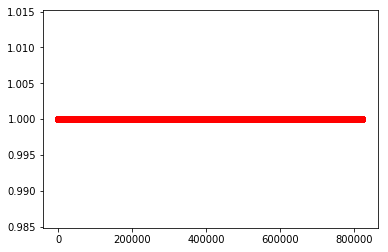

In [226]:
# import sys
# !conda install --yes --prefix {sys.prefix} matplotlib

import matplotlib.pyplot as plt

y = [1] * len(nonvalidIDs)
y2 = [1] * len(tempIDs)

plt.scatter(nonvalidIDs,y)
plt.scatter(tempIDs,y2,c='red')
plt.show()

We found 753 352 unique pattern IDs. We expected to find about 753 395 pattern IDs. This is probably due to patterns being added to Raverly while we were scraping. The number of pattern IDs found is quite close to the number of pattern IDs we expected, so we have successfully scraped nearly all of the Raverly pattern IDs! Yay!

The total time spent scraping was  249  minutes, or  4.15  hours.<br>
The smallest pattern ID found was 10, and the largest was 821 033. This is within reasonable expected values!

Scrape time for each category: 
Machine knitting: 1855 patterns in about 2 minutes, 428 patterns/min, requesting 100 patterns at a time<br>
Loom knitting: 3279 patterns in about 3 minutes, 1093 patterns/min, requesting 100 patterns at a time<br>
Crochet, 1-color: 44 061 in about 28 minutes, 1573 patterns/min, requesting 500 patterns at a time<br>
Crochet, multi-color: 12 472 patterns in about 5 minutes, 2495 patterns/min, requesting 1000 patterns at a time<br>
Knitting, multi-color: 43 529 patterns in 18 minutes, 2418 patterns/min, requesting 1000 patterns at a time<br>
Knitting, 1-color, rating 0,1,2,3: 40 388 patterns in 14 minutes, 2885 patterns/min, requesting 1000 patterns at a time<br>
Knitting, 1-color, rating 4: 68 684 patterns in 23 minutes, 2986 patterns/min, requesting 1000 patterns at a time<br>
Knitting, 1-color, rating 5: 86 470 patterns in 29 minutes, 2982 patterns/min, requesting 1000 patterns at a time<br>
K1: 16 min<br>
K2: 13 min<br>
K3: 17 min<br>
K4: 29 min<br>
C1: 22 min<br>
C2: 16 min<br>
C3: 27 min

Print the integers that are missing from the list of ID numbers, to get a sense of which integers there are? What is a better way to visualize this?

Do I need to watch for special characters e.g. Japanese? Will I have to do something like Steve did and convert stuff to Unicode?

I chose to use jupyter for the scraping of the IDs because I wanted to be able to keep track of everything I did. I wanted to work modularly, in chunks, so that I could check that everything was going well without committing my computer to scrape for hours before I could check on things. I wanted to proceed carefully, and avoid making unnecessary requests to the API to prevent hitting their rate limits.

In [227]:
print('hello')

hello
